<h1 align="center">MSIN0114: Business Analytics Consulting Project</h1>
<h2 align="center">S2R Analytics, pt. 3</h2>

# Table of Contents

* [Part 5](#part5): Regression
    * [5.0](#5_0): Data splitting
<br />
<br />
* [Part 6](#part6): Classification
    * [6.0](#6_0): Data splitting
<br />
<br />
* [Part 7](#part7): Decomposition
    * [7.0](#7_0): Data splitting
<br />
<br />
* [Part 8](#part8): Performance evaluation
* [Part 9](#part9): Feature importance and statistical tests
* [Part 10](#part10): Converting the output

## Notebook Setup

In [31]:
#Essentials
import pandas as pd
from pandas import Series, DataFrame
from pandas.api.types import CategoricalDtype
pd.options.display.max_columns = None
import sqlite3
import pyodbc
import numpy as np; np.random.seed(1)

#Image creation and display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib import pyplot
import plotly.express as px
import plotly.graph_objects as go
#from image import image, display

#Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

#Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier

#Metrics of accuracy
from numpy import mean
from numpy import std
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

#Other
import itertools as it
import io
import os
os.sys.path
import sys
import glob
import concurrent.futures
from __future__ import print_function
import binascii
import struct
from PIL import Image
import scipy
import scipy.misc
import scipy.cluster
import datetime, time
import functools, operator
from datetime import datetime
from numpy.random import seed
from numpy.random import randn
from numpy import percentile

In [32]:
df = pd.read_csv('csv-files/preprocessed_data.csv')

## Part 5: <a class="anchor" id="part5"></a> Regression

### 5.0 <a class="anchor" id="5_1"></a> Data splitting

In [33]:
# Choose dependent variables
Y = df[['Avg_Rec']]

# Drop the dependent variables from the feature data set
X = df.drop(columns = ['Avg_Profit', 'Avg_Rec', 'Rec_Class', 'Profit_Class'])

# Scale the explanatory variables
X1 = pd.DataFrame(preprocessing.normalize(X))
X1.columns = X.columns
X = X1

# Split data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=1)

print(f'No. of training data: {X_train.shape[0]}')
print(f'No. of training targets: {Y_train.shape[0]}')
print(f'No. of testing data: {X_test.shape[0]}')
print(f'No. of testing targets: {Y_test.shape[0]}')

No. of training data: 7704
No. of training targets: 7704
No. of testing data: 1927
No. of testing targets: 1927


In [38]:
Y

,Avg_Rec
0,0.901941
1,1.000000
2,0.832050
3,0.782964
4,1.000000
...,...
9626,0.853686
9627,0.853686
9628,0.853686
9629,0.853686


### 5.1 <a class="anchor" id="5_1"></a> Linear regression

In [34]:
lr = LinearRegression()
lr.fit(X_train, Y_train.values.ravel())

# Train data set
y_pred_train_lr = lr.predict(X_train)
lr_mse_train = mean_squared_error(Y_train, y_pred_train_lr)
lr_rmse_train = np.sqrt(lr_mse_train)
lr_r2_train = metrics.r2_score(Y_train, y_pred_train_lr)
print('Linear Regression R2 on train set: ', round(lr_r2_train, 2))

# Test data set
y_pred_test_lr = lr.predict(X_test)
lr_mse_test = mean_squared_error(Y_test, y_pred_test_lr)
lr_rmse_test = np.sqrt(lr_mse_test)
lr_r2_test = metrics.r2_score(Y_test, y_pred_test_lr)
print('Linear Regression R2 on test set: ', round(lr_r2_test, 2))

Linear Regression R2 on train set:  0.1
Linear Regression R2 on test set:  0.1


### 5.2 <a class="anchor" id="5_2"></a> Lasso regression

In [36]:
lasso = Lasso(random_state = 1)
lasso.fit(X_train, Y_train.values.ravel())

# Train data set
y_pred_train_lasso = lasso.predict(X_train)
lasso_mse_train = mean_squared_error(Y_train, y_pred_train_lasso)
lasso_rmse_train = np.sqrt(lasso_mse_train)
lasso_R2_train = metrics.r2_score(Y_train, y_pred_train_lasso)
print('Lasso Regression R2 on train set: ', round(lasso_R2_train, 2))

# Test data set
y_pred_test_lasso = lasso.predict(X_test)
lasso_mse_test = mean_squared_error(Y_test, y_pred_test_lasso)
lasso_rmse_test = np.sqrt(lasso_mse_test)
lasso_R2_test = metrics.r2_score(Y_test, y_pred_test_lasso)
print('Lasso Regression R2 on test set: ', round(lasso_R2_test, 2))

Lasso Regression R2 on train set:  0.0
Lasso Regression R2 on test set:  -0.0


### 5.3 <a class="anchor" id="5_3"></a> Decision tree regressor

In [37]:
dtr = DecisionTreeRegressor(random_state = 1)
dtr.fit(X_train, Y_train.values.ravel())

# Train data set
y_pred_train_dtr = dtr.predict(X_train)
dtr_mse_train = mean_squared_error(Y_train, y_pred_train_dtr)
dtr_rmse_train = np.sqrt(dtr_mse_train)
dtr_r2_train = metrics.r2_score(Y_train, y_pred_train_dtr)
print('Decision Tree R2 on train set: ', round(dtr_r2_train, 2))

# Test data set
y_pred_test_dtr = dtr.predict(X_test)
dtr_mse_test = mean_squared_error(Y_test, y_pred_test_dtr)
dtr_rmse_test = np.sqrt(dtr_mse_test)
dtr_r2_test = metrics.r2_score(Y_test, y_pred_test_dtr)
print('Decision Tree R2 on test set: ', round(dtr_r2_test, 2))

Decision Tree R2 on train set:  0.67
Decision Tree R2 on test set:  -0.51


### 5.4 <a class="anchor" id="5_4"></a> Random forest regressor

In [39]:
rfr = RandomForestRegressor(random_state = 1)
rfr.fit(X_train, Y_train.values.ravel())

# Train data set
y_pred_train_rfr = rfr.predict(X_train)
rfr_mse_train = mean_squared_error(Y_train, y_pred_train_rfr)
rfr_rmse_train = np.sqrt(rfr_mse_train)
rfr_R2_train = metrics.r2_score(Y_train, y_pred_train_rfr)
print('Random Forest R2 on train set: ', round(rfr_R2_train, 2))

# Test data set
y_pred_test_rfr = rfr.predict(X_test)
rfr_mse_test = mean_squared_error(Y_test, y_pred_test_rfr)
rfr_rmse_test = np.sqrt(rfr_mse_test)
rfr_R2_test = metrics.r2_score(Y_test, y_pred_test_rfr)
print('Random Forest R2 on test set: ', round(rfr_R2_test, 2))

Random Forest R2 on train set:  0.62
Random Forest R2 on test set:  -0.02


### 5.5 <a class="anchor" id="5_5"></a> XGBoost regressor

In [40]:
xgbr = XGBRegressor(random_state = 1)
xgbr.fit(X_train, Y_train.values.ravel())

# Train data set
y_pred_train_xgbr = xgbr.predict(X_train)
xgbr_mse_train = mean_squared_error(Y_train, y_pred_train_xgbr)
xgbr_rmse_train = np.sqrt(xgbr_mse_train)
xgbr_R2_train = metrics.r2_score(Y_train, y_pred_train_xgbr)
print('XGBoost R2 on train set: ', round(xgbr_R2_train, 2))

# Test data set
y_pred_test_xgbr = xgbr.predict(X_test)
xgbr_mse_test = mean_squared_error(Y_test, y_pred_test_xgbr)
xgbr_rmse_test = np.sqrt(xgbr_mse_test)
xgbr_R2_test = metrics.r2_score(Y_test, y_pred_test_xgbr)
print('XGBoost R2 on test set: ', round(xgbr_R2_test, 2))

XGBoost R2 on train set:  0.74
XGBoost R2 on test set:  0.26


c:\Users\MarfaPopova\S2R Analytics\Development & Support Team - Power BI for Synergy - Advanced Analytics\DataFlowExtract\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


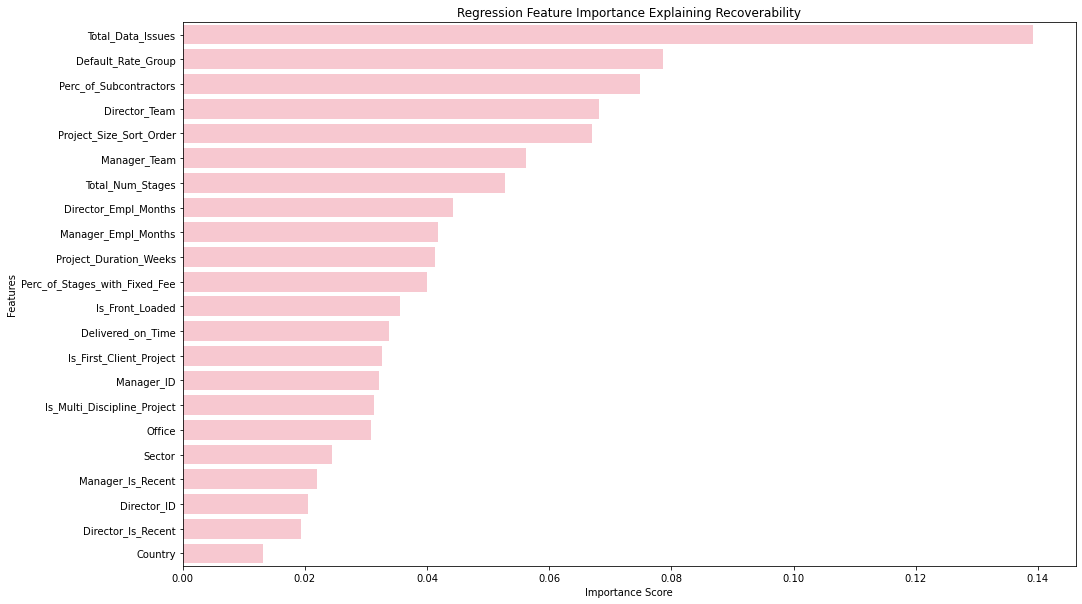

In [41]:
# Create a new DataFrame for feature importance
xgbr.feature_names = X.columns
final_feature_importance = pd.DataFrame({'Feature': xgbr.feature_names,'Importance':xgbr.feature_importances_})
final_feature_importance = final_feature_importance.sort_values(by = ['Importance'], ascending = False)

# Plotting the feature importance graph
fig, ax = plt.subplots(figsize = (16,10))
sns.barplot(final_feature_importance['Importance'], final_feature_importance['Feature'], color = 'pink')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.xticks(rotation = 'horizontal')
plt.title('Regression Feature Importance Explaining Recoverability')
plt.savefig('figures/Regression Feature Importance Explaining Recoverability.png')

### 5.6  <a class="anchor" id="5_6"></a> Models comparison

The highest R2 score is 0.26 by  XGBoost regressor, making regression models very unreliable in this case.

* Conclusion: Regression does not work for this dataset.
* Reason: The results of test dataset are way too diferent from nearly perfect training results of 0.98 and 0.88.
* Cause: The continuous uints of dependent varuable 'Avg_Rec' are very close to wach other, making it difficult for the algorithm to see a pattern between such similar distances between each point.
* Next: Classification should work better.

## Part 6: <a class="anchor" id="part6"></a> Classification

### 6.0 <a class="anchor" id="6_0"></a> Data splitting

In [23]:
# Choose dependent variables
Y = df[['Rec_Class']]

# Drop the dependent variables from the feature data set
X = df.drop(columns = ['Project_ID','Avg_Profit', 'Avg_Rec', 'Rec_Class', 'Profit_Class'])

# Scale the explanatory variables
#df_2 = pd.DataFrame(RobustScaler().fit_transform(X), columns=X.columns)

# Split data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=1, stratify = Y)

print(f'No. of training data: {X_train.shape[0]}')
print(f'No. of training targets: {Y_train.shape[0]}')
print(f'No. of testing data: {X_test.shape[0]}')
print(f'No. of testing targets: {Y_test.shape[0]}')

No. of training data: 7704
No. of training targets: 7704
No. of testing data: 1927
No. of testing targets: 1927


### 6.1 <a class="anchor" id="6_1"></a> Logistic regression

In [15]:
# Create a logistic regression model
log = LogisticRegression(random_state = 1)

# Train the model using train set
log.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
log_y_pred=lr.predict(X_test)

# Accuracy measures
print("Accuracy score of LR: " + str(round(metrics.accuracy_score(Y_test, np.round(log_y_pred)), 3)*100)+"%")
print("Precision score of LR: " + str(round(metrics.precision_score(Y_test, np.round(log_y_pred), average="weighted", zero_division=1), 3)*100)+"%")
print("Recall score of LR: " + str(round(metrics.recall_score(Y_test, np.round(log_y_pred), average="weighted"), 3)*100)+"%")
print("F1 of LR: " + str(round(metrics.f1_score(Y_test, np.round(log_y_pred), average="weighted"), 3)*100)+"%")

Accuracy score of LR: 46.9%
Precision score of LR: 72.1%
Recall score of LR: 46.9%
F1 of LR: 30.0%


### 6.2 <a class="anchor" id="6_2"></a> KNeighbors classifier

In [16]:
# Create KNN Classifier model
np.random.seed(1)
knn_3 = KNeighborsClassifier(n_neighbors = 3)

# Train the model using train set
knn_3.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
knn_3_y_pred = knn_3.predict(X_test)

# Accuracy measures
print("Accuracy score of KNN-3: " + str(round(metrics.accuracy_score(Y_test, np.round(knn_3_y_pred)), 3)*100)+"%")
print("Precision score of KNN-3: " + str(round(metrics.precision_score(Y_test, np.round(knn_3_y_pred), average="weighted", zero_division=1), 3)*100)+"%")
print("Recall score of KNN-3 " + str(round(metrics.recall_score(Y_test, np.round(knn_3_y_pred), average="weighted"), 3)*100)+"%")
print("F1 of KNN-3: " + str(round(metrics.f1_score(Y_test, np.round(knn_3_y_pred), average="weighted"), 3)*100)+"%")

Accuracy score of KNN-3: 56.10000000000001%
Precision score of KNN-3: 56.39999999999999%
Recall score of KNN-3 56.10000000000001%
F1 of KNN-3: 56.2%


In [17]:
np.random.seed(1)
knn_7 = KNeighborsClassifier(n_neighbors=7)
knn_7.fit(X_train, Y_train.values.ravel())
knn_7_y_pred = knn_7.predict(X_test)

print("Accuracy score of KNN-7: " + str(round(metrics.accuracy_score(Y_test, np.round(knn_7_y_pred)), 3)*100)+"%")
print("Precision score of KNN-7: " + str(round(metrics.precision_score(Y_test, np.round(knn_7_y_pred), average="weighted", zero_division=1), 3)*100)+"%")
print("Recall score of KNN-7 " + str(round(metrics.recall_score(Y_test, np.round(knn_7_y_pred), average="weighted"), 3)*100)+"%")
print("F1 of KNN-7: " + str(round(metrics.f1_score(Y_test, np.round(knn_7_y_pred), average="weighted"), 3)*100)+"%")

Accuracy score of KNN-7: 57.3%
Precision score of KNN-7: 56.10000000000001%
Recall score of KNN-7 57.3%
F1 of KNN-7: 56.599999999999994%


### 6.3 <a class="anchor" id="6_3"></a> Decision tree classifier

In [18]:
# Create Decision Tree Classifier model
dtc = DecisionTreeClassifier(random_state = 1)

# Train the model using train set
dtc = dtc.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
dtc_y_pred = dtc.predict(X_test)

# Accuracy measures
print("Accuracy score of DTC: " + str(round(metrics.accuracy_score(Y_test, np.round(dtc_y_pred)), 3)*100)+"%")
print("Precision score of DTC: " + str(round(metrics.precision_score(Y_test, np.round(dtc_y_pred), average="weighted", zero_division=1), 3)*100)+"%")
print("Recall score of DTC: " + str(round(metrics.recall_score(Y_test, np.round(dtc_y_pred), average="weighted"), 3)*100)+"%")
print("F1 of DTC: " + str(round(metrics.f1_score(Y_test, np.round(dtc_y_pred), average="weighted"), 3)*100)+"%")

Accuracy score of DTC: 62.3%
Precision score of DTC: 62.6%
Recall score of DTC: 62.3%
F1 of DTC: 62.4%


### 6.4 <a class="anchor" id="6_4"></a> Random forest classifier

In [19]:
# Create a Gaussian Classifier model
rfc = RandomForestClassifier(random_state = 1)

# Train the model using train set
rfc.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
rfc_y_pred=rfc.predict(X_test)

# Accuracy measures
print("Accuracy score of RFC: " + str(round(metrics.accuracy_score(Y_test, np.round(rfc_y_pred)), 3)*100)+"%")
print("Precision score of RFC: " + str(round(metrics.precision_score(Y_test, np.round(rfc_y_pred), average="weighted", zero_division=1), 3)*100)+"%")
print("Recall score of RFC: " + str(round(metrics.recall_score(Y_test, np.round(rfc_y_pred), average="weighted"), 3)*100)+"%")
print("F1 of RFC: " + str(round(metrics.f1_score(Y_test, np.round(rfc_y_pred), average="weighted"), 3)*100)+"%")

Accuracy score of RFC: 69.3%
Precision score of RFC: 68.2%
Recall score of RFC: 69.3%
F1 of RFC: 68.60000000000001%


### 6.5 <a class="anchor" id="6_5"></a> Gaussian classifier

In [20]:
# Create a XGBoost model
xgbc = XGBClassifier(n_estimators=100, learning_rate=0.05, booster='gbtree', random_state = 1)

# Train the model using train set
xgbc.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
xgbc_y_pred=xgbc.predict(X_test)

# Accuracy measures
print("Accuracy score of XGBC: " + str(round(metrics.accuracy_score(Y_test, np.round(xgbc_y_pred)), 3)*100)+"%")
print("Precision score of XGBC: " + str(round(metrics.precision_score(Y_test, np.round(xgbc_y_pred), average="weighted", zero_division=1), 3)*100)+"%")
print("Recall score of XGBC: " + str(round(metrics.recall_score(Y_test, np.round(xgbc_y_pred), average="weighted"), 3)*100)+"%")
print("F1 of XGBC: " + str(round(metrics.f1_score(Y_test, np.round(xgbc_y_pred), average="weighted"), 3)*100)+"%")

Accuracy score of XGBC: 70.7%
Precision score of XGBC: 69.6%
Recall score of XGBC: 70.7%
F1 of XGBC: 69.69999999999999%


c:\Users\MarfaPopova\S2R Analytics\Development & Support Team - Power BI for Synergy - Advanced Analytics\DataFlowExtract\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


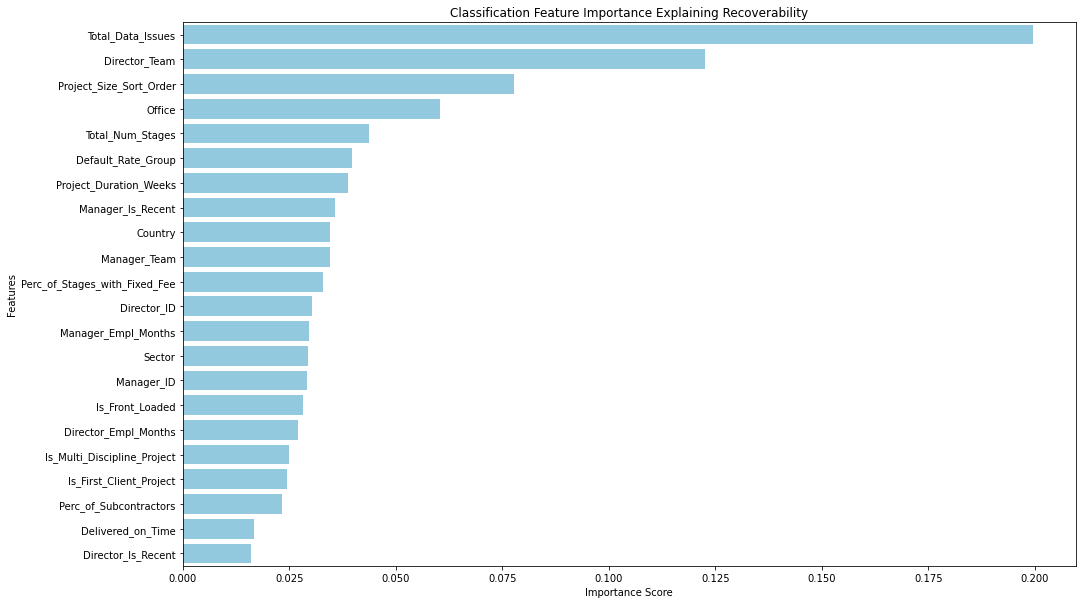

In [24]:
# Create a new DataFrame for feature importance
xgbc.feature_names = X.columns
final_feature_importance = pd.DataFrame({'Feature': xgbc.feature_names,'Importance':xgbc.feature_importances_})
final_feature_importance = final_feature_importance.sort_values(by = ['Importance'], ascending = False)

# Plotting the feature importance graph
fig, ax = plt.subplots(figsize = (16,10))
sns.barplot(final_feature_importance['Importance'], final_feature_importance['Feature'], color = 'skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.xticks(rotation = 'horizontal')
plt.title('Classification Feature Importance Explaining Recoverability')
plt.savefig('figures/Classification Feature Importance Explaining Recoverability.png')

### 6.6 <a class="anchor" id="6_6"></a> Naive Bayes

In [29]:
# Create a XGBoost model
gnb = GaussianNB()

# Train the model using train set
gnb.fit(X_train, Y_train.values.ravel())

# Predict the response for test set
gnb_y_pred = gnb.predict(X_test)

# Accuracy measures
print("Accuracy score of GNB: " + str(round(metrics.accuracy_score(Y_test, np.round(gnb_y_pred)), 3)*100)+"%")
print("Precision score of GNB: " + str(round(metrics.precision_score(Y_test, np.round(gnb_y_pred), average="weighted", zero_division=1), 3)*100)+"%")
print("Recall score of GNB: " + str(round(metrics.recall_score(Y_test, np.round(gnb_y_pred), average="weighted"), 3)*100)+"%")
print("F1 of GNB: " + str(round(metrics.f1_score(Y_test, np.round(gnb_y_pred), average="weighted"), 3)*100)+"%")

Accuracy score of GNB: 6.800000000000001%
Precision score of GNB: 59.599999999999994%
Recall score of GNB: 6.800000000000001%
F1 of GNB: 7.199999999999999%


### 6.7  <a class="anchor" id="6_7"></a> Models comparison

Gaussian classifier has resulted in the best scored among all metrics, varying between 69.1 and 70.0%. This model will proceed to fine-tuning and will be included in ensemble learning with second best model, random forest classifier.

* Conclusion: Regression does not work for this dataset.
* Reason: The results of test dataset are way too diferent from perfect training results of 0.9 and 1.
* Cause: The continuous uints of dependent varuable 'Avg_Rec' are very close to wach other, making it difficult for the algorithm to see a pattern between such similar distances between each point.
* Next: Classification should work better.

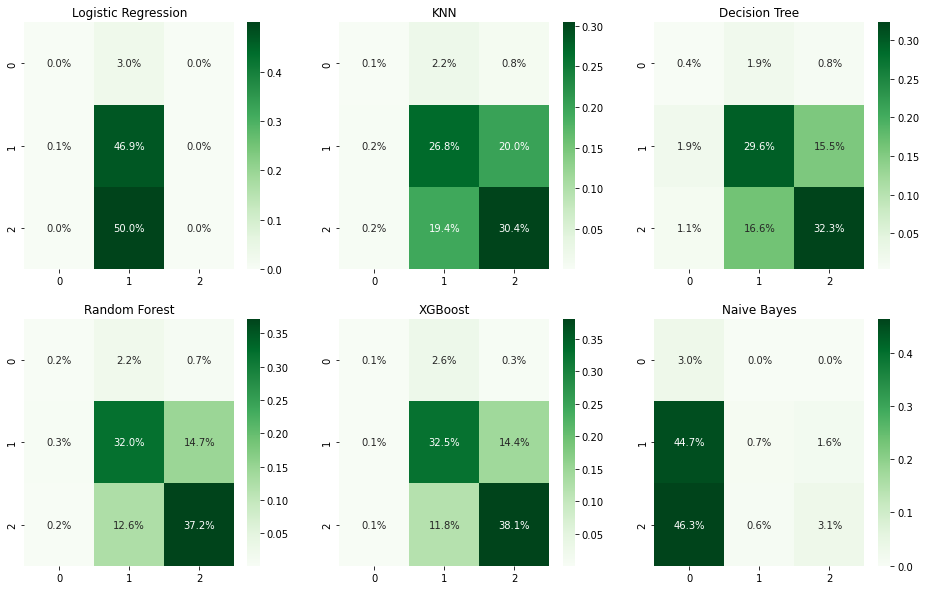

In [30]:
# Setting figure to compare the confusion matrix of each model based on heatmaps
fig, ax = plt.subplots(figsize = (16,10))
ax.set_title('Confusion matrix heatmaps of trained models', size = 17, pad = 10)

# Logistic model confusion matrix heatmap
plt.subplot(2,3,1)
sns.heatmap(confusion_matrix(Y_test, np.round(log_y_pred))/np.sum(confusion_matrix(Y_test, np.round(log_y_pred))), annot=True, fmt='.1%',cmap='Greens')
plt.title('Logistic Regression')

# KNN confusion matrix heatmap
plt.subplot(2,3,2)
sns.heatmap(confusion_matrix(Y_test, np.round(knn_7_y_pred))/np.sum(confusion_matrix(Y_test, np.round(knn_7_y_pred))), annot=True, fmt='.1%',cmap='Greens')
plt.title('KNN')

# Decision Tree classifier confusion matrix heatmap
plt.subplot(2,3,3)
sns.heatmap(confusion_matrix(Y_test, np.round(dtc_y_pred))/np.sum(confusion_matrix(Y_test, np.round(dtc_y_pred))), annot=True, fmt='.1%',cmap='Greens')
plt.title('Decision Tree')

# Random Forest classifier confusion matrix heatmap
plt.subplot(2,3,4)
sns.heatmap(confusion_matrix(Y_test, np.round(rfc_y_pred))/np.sum(confusion_matrix(Y_test, np.round(rfc_y_pred))), annot=True, fmt='.1%',cmap='Greens')
plt.title('Random Forest')

# XGBoost confusion matrix heatmap
plt.subplot(2,3,5)
sns.heatmap(confusion_matrix(Y_test, np.round(xgbc_y_pred))/np.sum(confusion_matrix(Y_test, np.round(xgbc_y_pred))), annot=True, fmt='.1%',cmap='Greens')
plt.title('XGBoost')

# Naive Bayes model confusion matrix heatmap
plt.subplot(2,3,6)
sns.heatmap(confusion_matrix(Y_test, np.round(gnb_y_pred))/np.sum(confusion_matrix(Y_test, np.round(gnb_y_pred))), annot=True, fmt='.1%',cmap='Greens')
plt.title('Naive Bayes')

plt.savefig('figures/All confusion matrices')

### 6.8  <a class="anchor" id="6_8"></a> Cross-validation

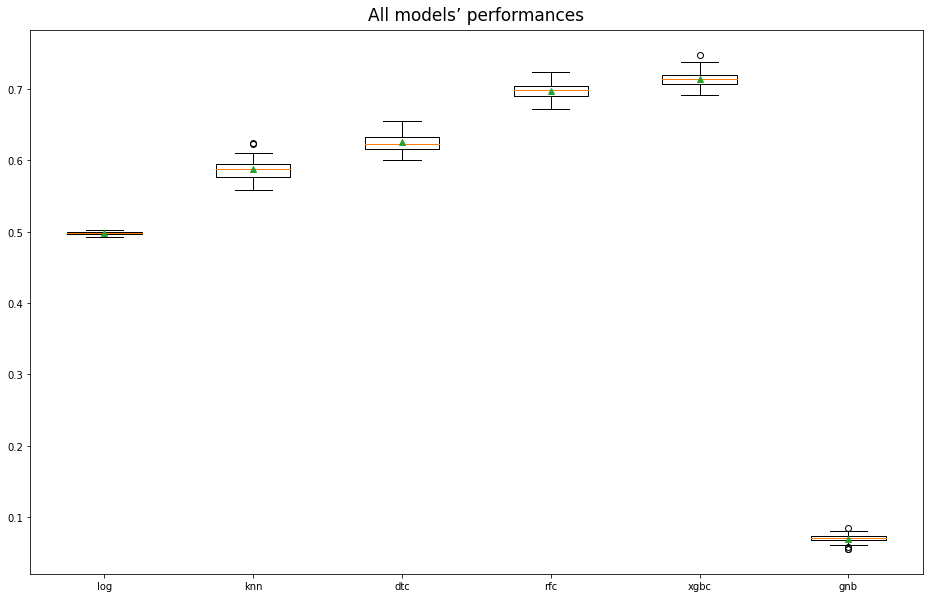

In [65]:
#URL: https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

fig, ax = plt.subplots(figsize = (16,10))

# get a list of models to evaluate
def get_models():
	models = dict()
	models['log'] = log
	models['knn'] = knn_7
	models['dtc'] = dtc
	models['rfc'] = rfc
	models['xgbc'] = xgbc
	models['gnb'] = gnb
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, Y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, Y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
  scores = evaluate_model(model, X, Y)
  results.append(scores)
  names.append(name)

# plot model performance for comparison
ax.set_title('All models’ performances', size = 17, pad = 10)
pyplot.boxplot(results, labels=names, showmeans=True)
fig.savefig('figures/All models’ performances', dpi=fig.dpi)

Orange lines indicate accuracy mean, green triangles - mean accuracy per model.

In [47]:
log_cv = cross_val_score(log, X_train, Y_train.values.ravel(), cv=6, scoring="accuracy")
print('LOG accuracy score is ' + str(round(log_cv[1],3)*100) + '%')

knn_cv = cross_val_score(knn_7, X_train, Y_train.values.ravel(), cv=6, scoring="accuracy")
print('KNN accuracy score is ' + str(round(knn_cv[1],3)*100) + '%')

dtc_cv = cross_val_score(dtc, X_train, Y_train.values.ravel(), cv=6, scoring="accuracy")
print('DTC accuracy score is ' + str(round(dtc_cv[1],3)*100) + '%')

rfc_cv = cross_val_score(rfc, X_train, Y_train.values.ravel(), cv=6, scoring="accuracy")
print('RFC accuracy score is ' + str(round(rfc_cv[1],3)*100) + '%')

xgbc_cv = cross_val_score(xgbc, X_train, Y_train.values.ravel(), cv=6, scoring="accuracy")
print('XGB accuracy score is ' + str(round(xgbc_cv[1],3)*100) + '%')

gnb_cv = cross_val_score(gnb, X_train, Y_train.values.ravel(), cv=6, scoring="accuracy")
print('GNB accuracy score is ' + str(round(gnb_cv[1],3)*100) + '%')

LOG accuracy score is 49.5%
KNN accuracy score is 57.199999999999996%
DTC accuracy score is 62.4%
RFC accuracy score is 68.10000000000001%
XGB accuracy score is 69.6%
GNB accuracy score is 6.2%


### 6.9  <a class="anchor" id="6_9"></a> Fine-tuning

#### 6.9.1  <a class="anchor" id="6_9_1"></a> XGBoost grid search

In [32]:
# Look at parameters used by our current XGBoost model
print('Parameters currently in use:\n')
pprint(xgbc.get_params())

Parameters currently in use:

{'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.05,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'objective': 'multi:softprob',
 'predictor': 'auto',
 'random_state': 1,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'use_label_encoder': False,
 'validate_parameters': 1,
 'verbosity': None}


In [33]:
#URL: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

# Defining parameter range
xgbc_grid = {'learning_rate':[0.1],
    'n_estimators':[1000],
    'max_depth':[4,5,6],
    'min_child_weight':[6,8,10,12],
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'objective':['binary:logistic'],
    'nthread':[4],
    'scale_pos_weight':[1],
    'seed':[1]}

pprint(xgbc_grid)

{'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
 'learning_rate': [0.1],
 'max_depth': [4, 5, 6],
 'min_child_weight': [6, 8, 10, 12],
 'n_estimators': [1000],
 'nthread': [4],
 'objective': ['binary:logistic'],
 'scale_pos_weight': [1],
 'seed': [1],
 'subsample': [0.6, 0.7, 0.8, 0.9]}


In [34]:
# Fitting the model for grid search
#xgb_tuned = GridSearchCV(XGBClassifier(), xgb_grid, refit = True)
#xgb_tuned.fit(X_train, Y_train.values.ravel())

In [35]:
# print best parameter after tuning
#print(xgb_tuned.best_params_)
 
# print how our model looks after hyper-parameter tuning
#print(xgb_tuned.best_estimator_)

In [36]:
# Base model results
#xgb_base_y_pred = xgb.predict(X_test)
#xgb_base_accuracy = round(metrics.accuracy_score(Y_test, np.round(xgb_base_y_pred)), 3)*100
#print('Accuracy of base XGB is ' + str(xgb_base_accuracy)+'%')

# Tuned model results
#xgb_tuned = xgb_tuned.best_estimator_
#xgb_tuned.fit(X_train, Y_train.values.ravel())
#xgb_tuned_y_pred = xgb_tuned.predict(X_test)
#xgb_tuned_accuracy = round(metrics.accuracy_score(Y_test, np.round(xgb_tuned_y_pred)), 3)*100

#print('Improvement of {:0.1f}%'.format(100 * (xgb_tuned_accuracy - xgb_base_accuracy) / xgb_base_accuracy))

#### 6.9.2  <a class="anchor" id="6_9_2"></a> Random forest classifier grid search

In [37]:
# Look at parameters used by our current random forest
#print('Parameters currently in use:\n')
#pprint(rfc.get_params())

In [38]:
# URL: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

#from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
#max_features = ['auto','sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]

# Create the random grid
#random_grid = {'n_estimators': n_estimators,
#                     'max_features': max_features,
#                     'max_depth': max_depth,
#                     'min_samples_split': min_samples_split,
#                      'min_samples_leaf': min_samples_leaf,
#                      'bootstrap': bootstrap}
#pprint(random_grid)

In [39]:
#rfc_tuned = RandomizedSearchCV(estimator = rfc,
#                               param_distributions = random_grid,
#                               n_iter = 100,
#                               cv = 6,
#                               verbose = 2,
#                               random_state = 1,
#                               n_jobs = -1)
# Fit the random search model
#rfc_tuned.fit(X_train, Y_train.values.ravel())

In [40]:
# Base model results
#rfc = RandomForestClassifier(random_state = 1)
#rfc.fit(X_train, Y_train.values.ravel())
#rfc_base_y_pred = rfc.predict(X_test)
#rfc_base_accuracy = round(metrics.accuracy_score(Y_test, np.round(rfc_base_y_pred)), 3)*100
#print('Accuracy of base RFC is ' + str(rfc_base_accuracy)+'%')

# Tuned model results
#rfc_tuned = rfc_tuned.best_estimator_
#rfc_tuned.fit(X_train, Y_train.values.ravel())
#rfc_tuned_y_pred = rfc_tuned.predict(X_test)
#rfc_tuned_accuracy = round(metrics.accuracy_score(Y_test, np.round(rfc_tuned_y_pred)), 3)*100

#print('Improvement of {:0.1f}%'.format(100 * (rfc_tuned_accuracy - rfc_base_accuracy) / rfc_base_accuracy))

#### 6.9.3  <a class="anchor" id="6_9_3"></a> Voting classifier

In [25]:
voting_clf = VotingClassifier(
    estimators=[('xgbc', xgbc), ('rfc', rfc)],
    voting='soft')

voting_clf.fit(X_train, Y_train.values.ravel())
voting_y_pred = voting_clf.predict(X_test)
print(classification_report(Y_test, np.round(voting_y_pred)))

              precision    recall  f1-score   support

           0       0.25      0.02      0.03        58
           1       0.70      0.70      0.70       906
           2       0.72      0.76      0.74       963

    accuracy                           0.71      1927
   macro avg       0.56      0.49      0.49      1927
weighted avg       0.70      0.71      0.70      1927



In [26]:
voting_accuracy = round(metrics.accuracy_score(Y_test, np.round(voting_y_pred)), 3)*100
print('Ultimate weighted average acccuracy of the model is ' + str(voting_accuracy)+'%')

Ultimate weighted average acccuracy of the model is 70.89999999999999%


#### 6.9.4  <a class="anchor" id="6_9_4"></a> Stacking

>log 0.497 (0.002)
>knn 0.587 (0.016)
>dtc 0.625 (0.012)
>rfc 0.697 (0.012)
>xgbc 0.714 (0.012)
>stacking 0.712 (0.013)


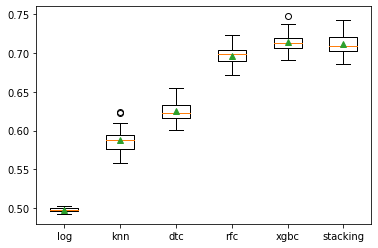

In [27]:
#URL: https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('log', log))
	level0.append(('knn', knn_7))
	level0.append(('dtc', dtc))
	level0.append(('rfc', rfc))
	level0.append(('xgbc', xgbc))

	# define meta learner model
	level1 = xgbc
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

# get a list of models to evaluate
def get_models():
	models = dict()
	models['log'] = log
	models['knn'] = knn_7
	models['dtc'] = dtc
	models['rfc'] = rfc
	models['xgbc'] = xgbc
	models['stacking'] = get_stacking()
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, Y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, Y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, Y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>voting 0.713 (0.013)
>rfc 0.697 (0.012)
>xgbc 0.714 (0.012)
>stacking 0.710 (0.014)


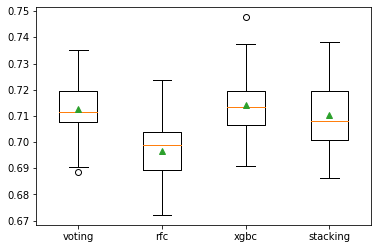

In [66]:
#URL: https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('voting', voting_clf))
	level0.append(('rfc', rfc))
	level0.append(('xgbc', xgbc))

	# define meta learner model
	level1 = xgbc
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

# get a list of models to evaluate
def get_models():
	models = dict()
	models['voting'] = voting_clf
	models['rfc'] = rfc
	models['xgbc'] = xgbc
	models['stacking'] = get_stacking()
	return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, Y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, Y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, Y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
fig.savefig('figures/Best models', dpi=fig.dpi)
pyplot.show()

The best fine-tuned model considered for final evaluation is defined below and is called 'final'.

In [28]:
# Define the base models
level0 = list()
level0.append(('rfc', rfc))
level0.append(('xgbc', xgbc))
level0.append(('voting', voting_clf))
level0.append(('stacking', get_stacking()))

# Define meta learner model
level1 = xgbc

# Define the final stacking ensemble
final = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

# Fit the model on all available data
final = final.fit(X, Y.values.ravel())

# Make a prediction for one example
random_project = X.sample(n=1)
yhat = final.predict(random_project)
print('Predicted Recoverability Class: %d' % (yhat))

Predicted Recoverability Class: 1


In [29]:
# Predict the response for test set
final_y_pred = final.predict(X_test)

In [76]:
# Accuracy measures
print('Accuracy score of final model: ' + str(round(metrics.accuracy_score(Y_test, np.round(final_y_pred)), 3)*100)+'%')
print('Precision score of final model: ' + str(round(metrics.precision_score(Y_test, np.round(final_y_pred), average='weighted', zero_division=1), 3)*100)+'%')
print('Recall score of final model: ' + str(round(metrics.recall_score(Y_test, np.round(final_y_pred), average='weighted'), 3)*100)+'%')
print('F1 of final model: ' + str(round(metrics.f1_score(Y_test, np.round(final_y_pred), average='weighted'), 3)*100)+"%")
final_cv = cross_val_score(final, X_train, Y_train.values.ravel(), cv=6, scoring='accuracy')
print('Final accuracy score on validation dataset is ' + str(round(final_cv[1],3)*100) + '%')

Accuracy score of final model: 82.39999999999999%
Precision score of final model: 80.10000000000001%
Recall score of final model: 82.39999999999999%
F1 of final model: 81.2%
Final accuracy score on validation dataset is 69.3%


### 6.10  <a class="anchor" id="6_10"></a> Evaluation

#### 6.10.1  <a class="anchor" id="6_10_1"></a> Confusion matrix

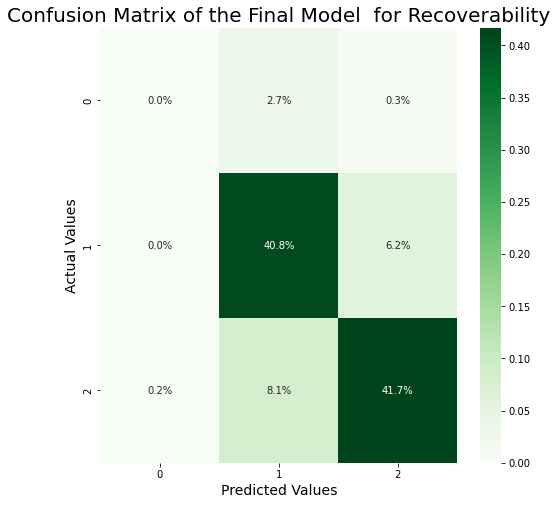

In [30]:
# Final model confusion matrix heatmap
plt.subplots(figsize = (8,8))
sns.heatmap(confusion_matrix(Y_test, np.round(final_y_pred))/np.sum(confusion_matrix(Y_test, np.round(final_y_pred))), annot=True, fmt='.1%',cmap='Greens')
plt.xlabel('Predicted Values', fontsize = 14) 
plt.ylabel('Actual Values', fontsize = 14)
plt.title('Confusion Matrix of the Final Model  for Recoverability', fontsize = 20)
plt.savefig('figures/Confusion Matrix of the Final Model for Recoverability.png')

The rate of correctly classified unsuccessful artists and successful artists is 86.82% and 7.75% respectively. 3.10% of observations were classified as successful artists whilst actually being unsuccessful (this is the false positive rate). 2.33% of observations were false negatives, meaning they were predicted to be unsuccessful but were in fact, successful artists. Overall 94.57% of the predictions are accurately classified – this is a good score considering the data at hand, thus, the model performed well on the test set.

#### 6.10.2  <a class="anchor" id="6_10_2"></a> ROC curve

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

#  Refresh data that is ultimately used
#X = df[['year', 'artwork_counts', 'tokens',
#             'media', 'collection',  'rights',
#             'creator', 'art_series', 'artwork_name', 'likes']]
#Y = df['price_class']

# Shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2022)

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Learn to predict each class against the other
RFC = RandomForestClassifier(100, random_state = 2022)
OVRC = OneVsRestClassifier(RFC)
OVRC.fit(X_train, y_train)

Let's compute macro-average ROC curve and ROC area.

In [ ]:
#URL: https://stackoverflow.com/questions/45332410/roc-for-multiclass-classification

from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

y = label_binarize(y, classes=[0,1,2])
n_classes = 3

# shuffle and split training and test sets
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.2, random_state=1)

# classifier
y_score = rfc_tuned.fit(X_train, y_train).predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Classifiers that give curves closer to the top-left corner indicate a better performance. As we can see, the curve for class 0 (cheap NFTs) VS all comes the closest to the ideal clinical discriminator, in comparison to the other 2 lines.

Class 1 (average NFTs) VS all has a moderate accuracy result, with AUC equal to 0.68 which feels like an average of our all trained models in chapter 6.

With the ROC curve being the closest o the 45-degree diagonal, class 3 (expensice NFTs) is the least accurate test, unfortunately, having nearly no predictive value.

#### 6.10.3  <a class="anchor" id="6_10_3"></a> Precision-Recall curve

In [ ]:
# Predict class values - THIS IS FOR BINARY CLASSIFICATION!
yhat = final_model.predict(X_test)
final_precision, final_recall, _ = precision_recall_curve(Y_test, np.round(final_probs))
final_f1, final_auc = f1_score(Y_test, yhat), auc(final_recall, final_precision)

# Summarize scores
print('Final model scores: f1=%.1f auc=%.1f' % (final_f1, final_auc))

# Plot the precision-recall curves
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No skill', color='orange')
pyplot.plot(final_recall, final_precision, marker='.', label='Final model', color='green')

pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
ax.set_title("Precision-recall curve", size = 17, pad = 10)
fig.savefig("Precision-recall curve.png", dpi=fig.dpi)

Given the imbalance between classes, the precision-recall relationship is analysed to further evaluate the success of the model’s classifications. Precision quantifies the number of predicted successful artists by the model which actually belongs to that class. Recall quantifies the number of ‘successful’ predictions out of all true successful instances in the data. AUC score is desired to be as high as possible, with the maximum being 1. The higher the score the higher both precision and recall will be. Thus, the model will return more accurate results (precision) whilst the majority of results returned is positive (recall). The models’ AUC is 0.688 which is satisfactory for the analysis.

#### 6.10.4  <a class="anchor" id="6_10_4"></a> Feature importance

In [87]:
from sklearn.model_selection import cross_validate
output = cross_validate(final, X, Y.values.ravel(), cv=5, scoring = 'accuracy', return_estimator = True)

for idx,estimator in enumerate(output['estimator']):
    print('Features sorted by their score for estimator {}:'.format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = final.feature_names,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

Features sorted by their score for estimator 0:


AttributeError: 'StackingClassifier' object has no attribute 'feature_importances_'

In [80]:
feature_imp = pd.Series(final.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_imp

AttributeError: 'StackingClassifier' object has no attribute 'feature_importances_'

In [ ]:
# Create a new DataFrame for feature importance
final.feature_names = X.columns
final_feature_importance = pd.DataFrame({'Feature': final.feature_names,'Importance':final.feature_importances_})
final_feature_importance = final_feature_importance.sort_values(by = ['Importance'], ascending = False)

# Plotting the feature importance graph
fig, ax = plt.subplots(figsize = (16,10))
sns.barplot(final_feature_importance['Importance'], final_feature_importance['Feature'], color = 'darkgreen')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.xticks(rotation = 'horizontal')
plt.title('Feature Importance')
plt.savefig('Feature Importance.png')

In [ ]:
# Plotting a bar plot for feature importance
%matplotlib inline

plt.figure(figsize = (14,7))
sns.barplot(rfc_tuned_feature_importance['Feature'], rfc_tuned_feature_importance['Importance'], color = 'darkgreen')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Feature Importance Score')
plt.xticks(rotation = 'vertical')
plt.legend()
plt.show()

In [ ]:
# Generating the model on all features

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=1, stratify=Y)

rfc_tuned.fit(X_train,Y_train.values.ravel())
y_pred=rfc_tuned.predict(X_test)
print('Accuracy of the final model with all features is ' + str(round(metrics.accuracy_score(Y_test, np.round(y_pred)), 3)*100)+'%')

In [ ]:
# 1 feature dropped

X = X[['artist_name', 'stream_count', 'total_user',	'artist_passion_score',
      'playlist_passion_score',	'artist_freq',	'playlist_var',
      'female_perc',	'dependent_perc',	'youngadult_perc',	'adult_perc',	'senior_perc']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=1, stratify=Y)

rfc_tuned.fit(X_train,Y_train.values.ravel())
y_pred=rfc_tuned.predict(X_test)
print('Accuracy of the final model with 1 feature dropped is ' + str(round(metrics.accuracy_score(Y_test, np.round(y_pred)), 3)*100)+'%')

Diminishing returns in performance occur after dropping just 1 feature, therefore all of the original features were kept to maintain maximum accuracy.

## Part 7: <a class="anchor" id="part7"></a> Decomposition

### 7.0 <a class="anchor" id="7_0"></a> Data splitting

In [ ]:
# Choose dependent variables
Y = df[['Rec_Class']]

# Drop the dependent variables from the feature data set
X = df.drop(columns = ['Project_ID','Avg_Profit', 'Avg_Rec', 'Rec_Class', 'Profit_Class'])

# Split data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=1, stratify = Y)

print(f'No. of training data: {X_train.shape[0]}')
print(f'No. of training targets: {Y_train.shape[0]}')
print(f'No. of testing data: {X_test.shape[0]}')
print(f'No. of testing targets: {Y_test.shape[0]}')

### 7.1 <a class="anchor" id="7_1"></a> Feature selection

### 7.2 <a class="anchor" id="7_2"></a> Feature extraction

### 7.3 <a class="anchor" id="7_3"></a> Locally Linear Embedding

In [33]:
df.drop(columns = ['Unnamed: 0', 'Project_ID'], inplace = True)
df

,Country,Office,Sector,Project_Size_Sort_Order,Project_Duration_Weeks,Total_Num_Stages,Is_Multi_Discipline_Project,Is_First_Client_Project,Default_Rate_Group,Perc_of_Stages_with_Fixed_Fee,Manager_ID,Manager_Team,Manager_Is_Recent,Manager_Empl_Months,Director_ID,Director_Team,Director_Is_Recent,Director_Empl_Months,Perc_of_Subcontractors,Is_Front_Loaded,Delivered_on_Time,Total_Data_Issues,Avg_Rec,Avg_Profit,Rec_Class,Profit_Class
0,0,7,6,4.0,4.0,5.0,0,1,1,0.80,7612852,7,0,125.0,7612709.0,6,0,431.0,0.0,1,1,2.0,0.901941,0.431859,2,1
1,0,4,0,1.0,238.0,4.0,0,1,1,0.00,7612773,4,0,317.0,7612747.0,4,0,431.0,0.0,0,1,2.0,1.000000,0.000000,2,0
2,0,4,0,1.0,0.0,2.0,0,1,1,0.00,7612773,4,0,317.0,7612768.0,4,0,337.0,0.0,0,1,0.0,0.832050,0.554700,2,1
3,0,4,1,3.0,121.0,4.0,0,1,1,0.25,7612773,4,0,317.0,7612709.0,6,0,431.0,0.0,0,1,1.0,0.782964,0.622067,2,1
4,0,4,0,7.0,2.0,6.0,0,1,1,0.00,7612695,4,0,419.0,7612695.0,4,0,419.0,0.0,0,1,3.0,1.000000,0.000000,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9626,0,4,9,3.0,18.0,2.0,0,0,0,1.00,7612752,5,0,176.0,7612691.0,5,0,175.0,0.0,0,1,1.0,0.853686,0.520788,2,1
9627,0,5,0,1.0,1.0,3.0,0,0,0,0.67,9501752,15,0,11.0,7859152.0,12,0,28.0,0.0,0,1,1.0,0.853686,0.520788,2,1
9628,0,6,0,1.0,1.0,2.0,0,0,0,0.50,7809410,16,0,28.0,10018105.0,6,1,4.0,0.0,0,1,1.0,0.853686,0.520788,2,1
9629,0,5,3,1.0,3.0,1.0,0,0,0,1.00,7612860,9,0,168.0,7612841.0,11,0,286.0,0.0,0,1,0.0,0.853686,0.520788,2,1


In [25]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=1)

In [26]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=1)
X_reduced = lle.fit_transform(X)

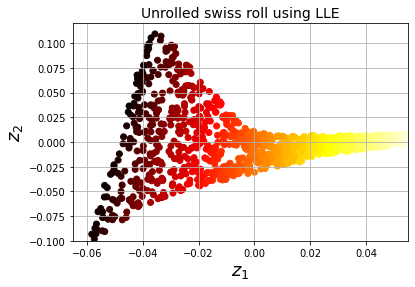

In [27]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)
plt.show()